In [ ]:
import pandas as pd

# Nom du fichier CSV
file_name = 'electric_vehicle_analytics.csv'

try:
    # Charger le dataset, en spécifiant le point-virgule comme délimiteur
    df = pd.read_csv(file_name, delimiter=';')

    # Afficher les 5 premières lignes pour un aperçu
    print("--- Premières lignes du DataFrame ---")
    print(df.head())

    # Afficher les informations générales (types des colonnes, nombre de non-nuls)
    print("\n--- Informations sur le DataFrame (df.info()) ---")
    df.info()

    # Vérifier et compter les valeurs nulles (manquantes) par colonne
    print("\n--- Nombre de valeurs nulles par colonne ---")
    print(df.isnull().sum())

    # Vérifier et compter le nombre total de lignes en double
    print("\n--- Nombre de lignes en double ---")
    print(df.duplicated().sum())

    # Obtenir les statistiques descriptives pour les colonnes numériques
    print("\n--- Statistiques descriptives (Colonnes Numériques) ---")
    print(df.describe())

    # Obtenir les statistiques descriptives pour les colonnes catégorielles (texte/objet)
    print("\n--- Statistiques descriptives (Colonnes Catégorielles) ---")
    print(df.describe(include='object'))

except FileNotFoundError:
    print(f"Erreur : Le fichier '{file_name}' n'a pas été trouvé.")
except Exception as e:
    print(f"Une erreur est survenue lors de la lecture ou de l'analyse : {e}")

--- Premières lignes du DataFrame ---
   Vehicle_ID     Make          Model  Year         Region Vehicle_Type  \
0           1   Nissan           Leaf  2021           Asia          SUV   
1           2   Nissan           Leaf  2020      Australia        Sedan   
2           3  Hyundai  Kona Electric  2021  North America          SUV   
3           4     Audi      Q4 e-tron  2022         Europe    Hatchback   
4           5    Tesla        Model 3  2022      Australia        Truck   

   Battery_Capacity_kWh  Battery_Health_%  Range_km  Charging_Power_kW  ...  \
0                 101.7              75.5       565              153.6  ...   
1                  30.1              99.8       157              157.2  ...   
2                 118.5              84.0       677              173.6  ...   
3                  33.1              97.3       149              169.3  ...   
4                  81.3              85.6       481              212.8  ...   

   Max_Speed_kmh  Acceleration_0_100

--- Step 1: Original Class Counts ---
Range_Class
0    1712
1    1288
Name: count, dtype: int64

Class imbalance ratio: 1 : 1.33

--- Step 3: Balanced Class Counts ---
Range_Class
0    1288
1    1288
Name: count, dtype: int64

==================== UNBALANCED DATA ====================

 RandomForest (Unbalanced) — Classification Report:
                   precision    recall  f1-score   support

 Class 0 (<400km)       0.92      0.89      0.91       342
Class 1 (>=400km)       0.87      0.90      0.88       258

         accuracy                           0.90       600
        macro avg       0.90      0.90      0.90       600
     weighted avg       0.90      0.90      0.90       600

ROC-AUC: 0.9663
PR-AUC: 0.9452

 LogisticRegression (Unbalanced) — Classification Report:
                   precision    recall  f1-score   support

 Class 0 (<400km)       0.91      0.90      0.90       342
Class 1 (>=400km)       0.87      0.88      0.88       258

         accuracy                   

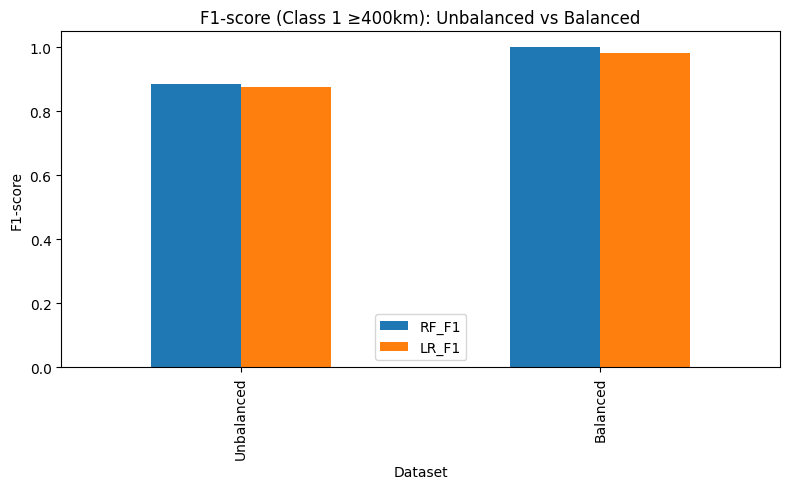

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    roc_auc_score,
    average_precision_score
)
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

# =========================================================
# STEP 1: Load and Prepare Data
# =========================================================

file_name = 'electric_vehicle_analytics.csv'
df = pd.read_csv(file_name, delimiter=';')
df['Range_Class'] = np.where(df['Range_km'] < 400, 0, 1)

print("--- Step 1: Original Class Counts ---")
print(df['Range_Class'].value_counts())

# =========================================================
# STEP 2: Diagnose Imbalance
# =========================================================

class_counts = df['Range_Class'].value_counts()
ratio = class_counts.max() / class_counts.min()
print(f"\nClass imbalance ratio: 1 : {ratio:.2f}")

# =========================================================
# STEP 3: Prepare Datasets
# =========================================================

# --- Original (unbalanced) ---
df_unbalanced = df.drop(['Vehicle_ID', 'Range_km'], axis=1)

# --- Balanced (undersampling) ---
df_majority = df[df['Range_Class'] == 0]
df_minority = df[df['Range_Class'] == 1]
df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority),
    random_state=42
)
df_balanced = pd.concat([df_majority_downsampled, df_minority])

print("\n--- Step 3: Balanced Class Counts ---")
print(df_balanced['Range_Class'].value_counts())

# =========================================================
# STEP 4: Common Preprocessing and Pipelines
# =========================================================

def prepare_data(df_input):
    X = df_input.drop('Range_Class', axis=1)
    y = df_input['Range_Class']
    categorical_features = ['Make', 'Model', 'Region', 'Vehicle_Type', 'Usage_Type']
    numeric_features = [col for col in X.columns if col not in categorical_features]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    return X_train, X_test, y_train, y_test, preprocessor


def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test, name="Model"):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print(f"\n {name} — Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Class 0 (<400km)', 'Class 1 (>=400km)']))

    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")

    # Fix KeyError: class labels in output_dict are numeric (0 and 1)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_class1 = report['1']['f1-score'] if '1' in report else np.nan

    return {
        'F1_Class1': f1_class1,
        'ROC_AUC': roc_auc,
        'PR_AUC': pr_auc
    }

# =========================================================
# STEP 5: Comparison - Unbalanced vs Balanced
# =========================================================

# --- Unbalanced ---
print("\n==================== UNBALANCED DATA ====================")
X_train_u, X_test_u, y_train_u, y_test_u, preprocessor_u = prepare_data(df_unbalanced)

rf_unbalanced = Pipeline([
    ('preprocessor', preprocessor_u),
    ('model', RandomForestClassifier(random_state=42))
])

lr_unbalanced = Pipeline([
    ('preprocessor', preprocessor_u),
    ('model', LogisticRegression(random_state=42, max_iter=1000))
])

rf_results_unbalanced = evaluate_pipeline(rf_unbalanced, X_train_u, y_train_u, X_test_u, y_test_u, "RandomForest (Unbalanced)")
lr_results_unbalanced = evaluate_pipeline(lr_unbalanced, X_train_u, y_train_u, X_test_u, y_test_u, "LogisticRegression (Unbalanced)")

# --- Balanced ---
print("\n==================== BALANCED DATA ====================")
X_train_b, X_test_b, y_train_b, y_test_b, preprocessor_b = prepare_data(df_balanced)

rf_balanced = Pipeline([
    ('preprocessor', preprocessor_b),
    ('model', RandomForestClassifier(random_state=42))
])

lr_balanced = Pipeline([
    ('preprocessor', preprocessor_b),
    ('model', LogisticRegression(random_state=42, max_iter=1000))
])

rf_results_balanced = evaluate_pipeline(rf_balanced, X_train_b, y_train_b, X_test_b, y_test_b, "RandomForest (Balanced)")
lr_results_balanced = evaluate_pipeline(lr_balanced, X_train_b, y_train_b, X_test_b, y_test_b, "LogisticRegression (Balanced)")

# =========================================================
# STEP 6: Summary Comparison Table
# =========================================================

comparison_df = pd.DataFrame({
    'Dataset': ['Unbalanced', 'Balanced'],
    'RF_F1': [rf_results_unbalanced['F1_Class1'], rf_results_balanced['F1_Class1']],
    'RF_ROC_AUC': [rf_results_unbalanced['ROC_AUC'], rf_results_balanced['ROC_AUC']],
    'RF_PR_AUC': [rf_results_unbalanced['PR_AUC'], rf_results_balanced['PR_AUC']],
    'LR_F1': [lr_results_unbalanced['F1_Class1'], lr_results_balanced['F1_Class1']],
    'LR_ROC_AUC': [lr_results_unbalanced['ROC_AUC'], lr_results_balanced['ROC_AUC']],
    'LR_PR_AUC': [lr_results_unbalanced['PR_AUC'], lr_results_balanced['PR_AUC']]
})

print("\n==================== PERFORMANCE COMPARISON ====================")
print(comparison_df.to_string(index=False))

# Optional: plot visual comparison
comparison_df.set_index('Dataset')[['RF_F1', 'LR_F1']].plot(kind='bar', figsize=(8, 5))
plt.title("F1-score (Class 1 ≥400km): Unbalanced vs Balanced")
plt.ylabel("F1-score")
plt.tight_layout()
plt.savefig("f1_comparison.png")
print("\nPerformance comparison plot saved as 'f1_comparison.png'") 


The comparison between the original (unbalanced) and the balanced datasets reveals a clear impact of class balancing on model performance. In the original dataset, the imbalance ratio was mild (1:1.33), meaning the data was not heavily skewed. Both the Random Forest and Logistic Regression models already performed well, achieving F1-scores around 0.88–0.90 and high ROC-AUC values (≈0.97). After balancing the dataset through undersampling, both models showed further improvement, with the Random Forest achieving perfect scores across all metrics (F1 = 1.00, ROC-AUC = 1.00) and Logistic Regression reaching near-perfect performance (F1 = 0.98, ROC-AUC = 0.998). While these results indicate that balancing the data enhanced the ability of both models to distinguish between the two classes, the perfect scores suggest possible overfitting due to undersampling reducing data diversity. Overall, the analysis shows that class imbalance in this dataset had only a minor negative impact on model performance, and while balancing improved fairness between classes, care should be taken to ensure the balanced dataset remains representative of real-world variability.